Импорт библиотек

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, logging
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset
import shutil
import matplotlib.pyplot as plt

Удаление сообщения
```bash
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```
потому что меня оно бесит...

In [2]:
logging.set_verbosity_error()

Базовая подготовка данных перед токенизацией и обучением модели

In [3]:
MODEL_DIR = "models/roberta-toxic"  # путь, куда будет сохранена обученная модель и токенизатор после обучения
MODEL_NAME = "roberta-base"         # имя предобученной модели, которая будет использоваться как основа 

# чтение очищенных данных, подготовленных скриптом очистки
train_df = pd.read_csv("data/preprocessed/clean_train.csv", sep=";")
test_df = pd.read_csv("data/preprocessed/clean_test.csv", sep=";")

# преобразование обычных DataFrame из pandas в формат Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

Объявление основных гиперпараметров обучения

In [4]:
BATCH_SIZE = 8  # размер пакета данных
EPOCHS = 3      # количество полных проходов модели по всему тренировочному набору данных
LR = 1e-5       # скорость обучения

Этап токенизации и преобразования данных в формат, подходящий для обучения нейросети

In [5]:
# загрузка токенизатора, связанного с выбранной моделью
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# определение функции токенизации для одной записи
def tokenize_function(example):
    return tokenizer(example["message"], padding="max_length", truncation=True, max_length=128)

# применение токенизации ко всему датасету
train_enc = train_dataset.map(tokenize_function, batched=True)
test_enc = test_dataset.map(tokenize_function, batched=True)

# перевод датасета в формат, совместимый с PyTorch
train_enc.set_format("torch", columns=["input_ids", "attention_mask", "is_toxic"])
test_enc.set_format("torch", columns=["input_ids", "attention_mask", "is_toxic"])

Map:   0%|          | 0/12707 [00:00<?, ? examples/s]

Map:   0%|          | 0/228 [00:00<?, ? examples/s]

Определение, на каком устройстве будет выполняться обучение и инференс модели

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # проверка доступен ли GPU
# результат сохраняется в переменной device
print("Используем устройство:", device)

Используем устройство: cuda


Механизм загрузки или обучения модели

In [7]:
# проверка есть ли уже обученная модель
if os.path.exists(MODEL_DIR):
    print("Найдена сохранённая модель, загружаем...")
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)

# создание и обучение модели если её нет, а после сохранение
else:
    print("Сохранённая модель не найдена, создаём новую и обучаем...")
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    model.to(device)
    train_loader = DataLoader(train_enc, batch_size=BATCH_SIZE, shuffle=True)
    optimizer = AdamW(model.parameters(), lr=LR)
    loss_fn = torch.nn.CrossEntropyLoss()
    shutil.rmtree(MODEL_DIR, ignore_errors=True)
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
        for batch in loop:
            optimizer.zero_grad()
            inputs = {k: v.to(device) for k, v in batch.items() if k != "is_toxic"}
            labels = batch["is_toxic"].to(device)
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        print(f"Средняя потеря за эпоху {epoch + 1}: {total_loss / len(train_loader):.4f}")
    model.save_pretrained(MODEL_DIR)
    tokenizer.save_pretrained(MODEL_DIR)
    print("\nМодель и токенизатор сохранены в", MODEL_DIR)


Найдена сохранённая модель, загружаем...


Этап оценки модели

In [8]:
# подготовка модели и данных
model.to(device)    # перенос модели на GPU
model.eval()        # перевод её в режим оценки
test_loader = DataLoader(test_enc, batch_size=BATCH_SIZE) # создание генератора пакетов
preds, labels = [], []
with torch.no_grad(): # контекстный менеджер, который запрещает вычисление градиентов
    # проход по тестовым пакетам
    for batch in tqdm(test_loader, desc="Оценка"):
        inputs = {k: v.to(device) for k, v in batch.items() if k != "is_toxic"}
        y_true = batch["is_toxic"].to(device)
        outputs = model(**inputs)
        y_pred = torch.argmax(outputs.logits, dim=1)
        preds.extend(y_pred.cpu().numpy())
        labels.extend(y_true.cpu().numpy())

Оценка:   0%|          | 0/29 [00:00<?, ?it/s]

Оценка качества модели и визуализация результатов классификации

              precision    recall  f1-score   support

           0      0.955     0.899     0.926       119
           1      0.897     0.954     0.924       109

    accuracy                          0.925       228
   macro avg      0.926     0.927     0.925       228
weighted avg      0.927     0.925     0.925       228

F1-score: 0.924


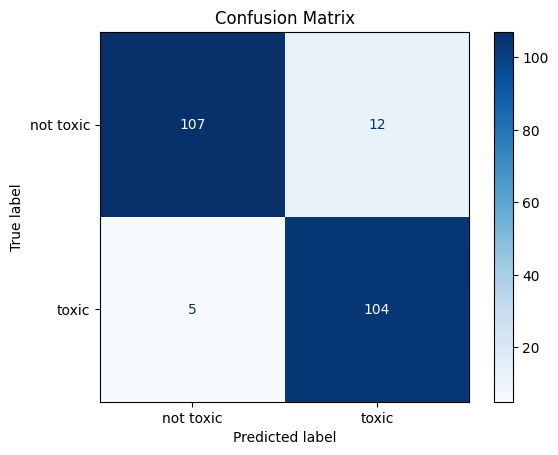

In [9]:
print(classification_report(labels, preds, digits=3)) # текстовый отчёт по метрикам
print("F1-score:", round(f1_score(labels, preds), 3)) # вычисление общей метрики качества

# матрица ошибок
cm = confusion_matrix(labels, preds)
ConfusionMatrixDisplay(cm, display_labels=["not toxic", "toxic"]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

Блок для извлечения веса финального классификатора RoBERTa и на их основе аналитики, 
какие токены (слова/части слов) модель считает наиболее “токсичными” и “нетоксичными”.

In [10]:
classifier_weights = model.classifier.state_dict()["out_proj.weight"].detach().cpu().numpy()
classifier_bias = model.classifier.state_dict()["out_proj.bias"].detach().cpu().numpy()
top_toxic_idx = np.argsort(classifier_weights[1])[-15:][::-1]
top_nontoxic_idx = np.argsort(classifier_weights[1])[:15]
vocab = list(tokenizer.get_vocab().keys())

Вывод топа токсичных токенов

In [11]:
print("Топ токсичных токенов:")
for idx in top_toxic_idx:
    print(f"{vocab[idx]:<20} {classifier_weights[1][idx]:.3f}")

Топ токсичных токенов:
ĠAntarctica          0.049
Lou                  0.046
ĠLester              0.041
blems                0.041
Ġphilosopher         0.041
itures               0.040
Ġjournals            0.039
limit                0.039
aunt                 0.039
alty                 0.038
Ġphase               0.037
quel                 0.037
awa                  0.036
Ġsupporting          0.035
creation             0.033


Вывод топа нетоксичных токенов

In [12]:
print("Топ нетоксичных токенов:")
for idx in top_nontoxic_idx:
    print(f"{vocab[idx]:<20} {classifier_weights[1][idx]:.3f}")

Топ нетоксичных токенов:
Ġyells               -0.050
ization              -0.046
gam                  -0.044
Tony                 -0.042
Fax                  -0.042
ĠCathedral           -0.042
ĠMcGee               -0.042
ĠAnglo               -0.041
itans                -0.041
Ġsoak                -0.040
Ġafloat              -0.040
ĠHUM                 -0.040
ĠEffect              -0.039
Ġprett               -0.037
Ġagric               -0.037
